# Interpretable Qindex Prediction of Al-Zn-Mg-Cu Alloys based on Hybrid XGBoost and Symbolic Regression Approach

### 1. Feature Engineering:  Pearson Correlation Analysis + Permutation Importance Analysis

In [18]:
import pandas as pd
import numpy as np
from scipy import stats

# 加载数据
df = pd.read_excel('...', sheet_name='...')

# 设置列索引
start_col_index = 1
end_col_index = 138
target_col_index = 139

# 获取列名
feature_columns = df.columns[start_col_index-1:end_col_index].tolist()
target_column = df.columns[target_col_index-1]

# 结果存储
results = []

for feature in feature_columns:
    valid_data = df[[feature, target_column]].dropna()
    x = valid_data[feature]
    y = valid_data[target_column]
    
    if x.nunique() <= 1:
        continue

    try:
        pearson_corr, p_value = stats.pearsonr(x, y)
    except Exception as e:
        print(f"{feature} 出错: {e}")
        continue

    # Fisher Z 变换
    n = len(x)
    z = np.arctanh(pearson_corr)
    se = 1 / np.sqrt(n - 3)
    z_lower = z - 1.96 * se
    z_upper = z + 1.96 * se
    ci_lower = np.tanh(z_lower)
    ci_upper = np.tanh(z_upper)

    # 归一化
    min_val = x.min()
    max_val = x.max()
    mean_val = x.mean()
    normalized_mean = (mean_val - min_val) / (max_val - min_val) if max_val != min_val else 0

    results.append({
        'Feature': feature,
        'Pearson': pearson_corr,
        'ABS_Pearson': abs(pearson_corr),
        'P-value': p_value,
        'Pearson_CI_Lower': ci_lower,
        'Pearson_CI_Upper': ci_upper,
        'Normalized_Min': 0,
        'Normalized_Max': 1,
        'Normalized_Mean': normalized_mean,
        'Original_Min': min_val,
        'Original_Max': max_val,
        'Original_Mean': mean_val
    })

# 转换为 DataFrame 并排序
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='ABS_Pearson', ascending=False)

# 保存结果
output_path = '/Users/zixuanzhao/Desktop/特征相关性分析结果.xlsx'
results_df.to_excel(output_path, index=False)

print(f"✅ 分析完成，包含 Pearson 置信区间上下限，结果已保存至：{output_path}")

FileNotFoundError: [Errno 2] No such file or directory: '...'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

# === Step 1: 读取数据 ===
data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')

# 提取特征与目标变量
X = data.iloc[:, 1:44].copy()  # 特征列（第2~44列）
y = data.iloc[:, 44]           # 目标列（第45列）

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Step 2: 随机森林 + permutation importance ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# 计算特征重要性（打乱测试）
perm_result = permutation_importance(model, X_scaled, y, n_repeats=10, random_state=42)

# 排序
importances = perm_result.importances_mean
indices = np.argsort(importances)[::-1]
top_43_idx = indices[:43]

# 打印前15个重要变量
print("=== Top 43 Features by Permutation Importance ===")
for i in range(43):
    feature_name = X.columns[top_43_idx[i]]
    score = importances[top_43_idx[i]]
    print(f"{i+1:2d}. {feature_name:20s} Importance: {score:.6f}")

## 2. Symbolic Regression based on Deepseek-math-7b

In [ ]:
import requests

# 填写你的Hugging Face Token
API_TOKEN = "..."  # 替换为你的实际Token
API_URL = "https://api-inference.huggingface.co/models/deepseek-ai/deepseek-math-7b-base"

headers = {"Authorization": f"Bearer {API_TOKEN}"}

def query(prompt):
    # 发送POST请求，输入为JSON格式的prompt
    response = requests.post(API_URL, headers=headers, json={"inputs": prompt})
    return response.json()

# 示例：生成数学公式
prompt = """
Assume you are an expert in materials science and symbolic regression. Based on the detailed variable relationships below, generate 20 candidate mathematical expressions to fit the residuals of the Material Qindex.
1. Variable Categories and Descriptions:
	•	Processing Parameters:
	•	3rd_Aging_Temperature: third-stage aging temperature | processing parameter | Pearson=+0.946
	•	2nd_Aging_Temperature: second-stage aging temperature | processing parameter | Pearson=+0.695
	•	Physicochemical Properties:
	•	Tmelt: melting point | intrinsic property | Pearson=+0.196
	•	DeltaHmix: mixing enthalpy | thermodynamic parameter | Pearson=-0.150
	•	Omega: atomic size mismatch parameter | crystal structure | Pearson=+0.158
	•	VECi: valence electron concentration | electronic structure | Pearson=-0.139
	•	Compositional Factors (elemental content or ratios):
	•	Zn: zinc content | alloy element | Pearson=-0.185
	•	Zn+Mg: total Zn and Mg | combined elements | Pearson=-0.178
	•	Zn*Mg/Ti: Zn-Mg-Ti interaction | precipitate-related | Pearson=-0.176
	•	Zn/(Zn+Mg+Cu): Zn proportion | compositional balance | Pearson=-0.168
	•	Zn*Mg/Zr: Zn-Mg-Zr interaction | grain boundary strengthening | Pearson=-0.165
	•	Zn/Zr: Zn to Zr ratio | phase composition influence | Pearson=-0.163
	•	Zn*Mg/Cu: Zn-Mg-Cu interaction | conductivity-related | Pearson=-0.161
	•	Zn/(Zn+Cu): Zn to Cu ratio | electrochemical property | Pearson=-0.159
	•	Zn*Mg/Sc: Zn-Mg-Sc interaction | nano-precipitation | Pearson=-0.140
	•	Zn/(Zn+Sc): Zn to Sc ratio | rare-earth effect | Pearson=-0.140
	•	Zn/(Zn+Ti): Zn to Ti ratio | phase stability | Pearson=-0.136
	•	Zn/Mg: Zn to Mg ratio | strengthening phase balance | Pearson=-0.135
	•	WtSlotue/ATsolvent: solid solubility / atomic weight of solvent | solubility potential | Pearson=-0.14
	•	Zn*Cu/Zr: Zn-Cu-Zr interaction | complex precipitation | Pearson=-0.13
	•	Strengthening Element Combinations:
	•	Zr+Sc+Ti: sum of Zr, Sc, Ti | composite microalloying | Pearson=+0.169
	•	Ti: Ti content | single microalloying element | Pearson=+0.139
2. Formula Generation Rules:
	•	Each formula should try to include variables from all major categories, namely: At least one processing parameter, at least one physicochemical property, 
 at least one compositional factor, and optionally one strengthening combination term, to ensure coverage of multiple feature types per formula.
	•	Allowed operators/functions: +, -, *, /, sin(), cos(), exp(), sqrt()
	•	Typical structure examples:
	•	"exp(-0.2*Zn) * (3rd_Aging_Temperature + Omega)"
	•	"(Zr+Sc+Ti) / (1 + sqrt(Zn*Mg/Ti)) - DeltaHmix/100"
	•	Strict constraints:
	•	Positively correlated variables must appear in the numerator or as positive terms.
	•	Negatively correlated variables must appear in the denominator or as negative terms.
	•	Avoid invalid expressions:
	•	No sqrt(negative number)
	•	No log(x) where x <= 0
	•	No division by zero.
"""

output = query(prompt)
print(output)

### Constant1 * Feature1 * Feature2 * (Feature3 + Constant2 * cos(Feature4 + Constant3 * Feature5)) + Constant4 * cos(Feature6) 
### Format1: c1 * f1 * f3 * (f3 + c2 * cos(f4 + c3 * f2)) + c4 * cos(f3)
### Format2: cos((f1 + f2) * sin(c1/f3)) * sin(c2 + sin(c3 / (cos(f4) - c4)))

In [ ]:
import pandas as pd
import numpy as np
import itertools
import os
import time
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

# === 1. 数据加载 ===
def load_data():
    data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')
    X = data.iloc[:, 1:44].copy()
    y = data.iloc[:, 44]
    X.columns = [f'F{i+1}' for i in range(X.shape[1])]
    return X, y

# === 2. 特征选择 ===
def select_top_features(X, y, top_n=12):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    importances = pd.Series(result.importances_mean, index=X.columns)
    return importances.sort_values(ascending=False).head(top_n).index.tolist()

# === 3. 自定义公式求值 ===
def evaluate_formula(constants, X, y, features, feature_order):
    c1, c2, c3, c4 = constants
    feature_names = [features[i] for i in feature_order]
    f1 = X[feature_names[0]]
    f2 = X[feature_names[1]]
    f3 = X[feature_names[2]]
    f4 = X[feature_names[3]] if len(feature_names) >= 4 else f3

    try:
        term = c1 * f1 * f3 * (f3 + c2 * np.cos(f4 + c3 * f2)) + c4 * np.cos(f3)
        y_pred = np.nan_to_num(term, nan=0.0, posinf=0.0, neginf=0.0)
        mse = mean_squared_error(y, y_pred)
        return mse
    except Exception as e:
        print(f"计算错误: {e}")
        return float('inf')

# === 4. 常数优化 ===
def optimize_constants(X, y, features, feature_order):
    """
    对于给定的特征组合和顺序，优化常数以最小化MSE
    """
    # 定义目标函数
    def objective(constants):
        return evaluate_formula(constants, X, y, features, feature_order)
    
    # 使用多个初始值进行优化，选择最好的结果
    best_result = None
    best_mse = float('inf')
    
    # 不同的初始值
    initial_guesses = [
        [1.0, 1.0, 1.0, 1.0],
        [0.5, 0.5, 0.5, 0.5],
        [2.0, 2.0, 2.0, 2.0],
        [1.0, 2.0, 0.5, 1.5],
        [0.1, 0.1, 0.1, 0.1],
        [-1.0, -1.0, -1.0, -1.0],
        [-2.0, 2.0, -2.0, 2.0],
        [3.0, -3.0, 3.0, -3.0]
    ]
    
    for init_guess in initial_guesses:
        try:
            # 扩大常数的范围到 -4 到 4
            bounds = [(-4, 4), (-4, 4), (-4, 4), (-4, 4)]
            result = minimize(
                objective, 
                init_guess, 
                method='L-BFGS-B',
                bounds=bounds,
                options={'maxiter': 1000}
            )
            
            if result.success:
                print(f"      成功优化: constants = {result.x}, train_mse = {result.fun:.6f}")
                if result.fun < best_mse:
                    best_result = result
                    best_mse = result.fun
        except Exception as e:
            print(f"优化失败 {init_guess}: {e}")
    
    if best_result is None:
        return None, float('inf')
    
    return best_result.x, best_mse

# === 5. 评估模型 ===
def evaluate_model(constants, X, y, features, feature_order):
    c1, c2, c3, c4 = constants
    feature_names = [features[i] for i in feature_order]
    f1 = X[feature_names[0]]
    f2 = X[feature_names[1]]
    f3 = X[feature_names[2]]
    f4 = X[feature_names[3]] if len(feature_names) >= 4 else f3

    try:
        y_pred = c1 * f1 * f3 * (f3 + c2 * np.cos(f4 + c3 * f2)) + c4 * np.cos(f3)
        y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
        r2 = r2_score(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        mae = mean_absolute_error(y, y_pred)
        return r2, rmse, mae, y_pred
    except Exception as e:
        print(f"评估错误: {e}")
        return float('-inf'), float('inf'), float('inf'), None

# === 6. 生成公式字符串 ===
def get_formula_string(features, constants, feature_order):
    c1, c2, c3, c4 = constants
    feature_names = [features[i] for i in feature_order]
    f1 = feature_names[0]
    f2 = feature_names[1]
    f3 = feature_names[2]
    f4 = feature_names[3] if len(feature_names) >= 4 else f3

    formula = (
        f"{c1:.4f}*{f1}*{f3}*({f3}+{c2:.4f}*cos({f4}+{c3:.4f}*{f2}))+{c4:.4f}*cos({f3})"
    )
    return formula

# === 7. 主函数 ===
def main():
    start_time = time.time()

    # 设置工作目录
    os.chdir("/Users/zixuanzhao/Desktop")

    print("加载数据...")
    X, y = load_data()

    print("选择顶级特征...")
    top_features = select_top_features(X, y, top_n=12)
    X_top = X[top_features]

    print(f"选择的顶级特征: {top_features}")

    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

    results = []

    combinations_3 = list(itertools.combinations(top_features, 3))
    combinations_4 = list(itertools.combinations(top_features, 4))
    all_combinations = combinations_3 + combinations_4

    permutations_count = sum(6 if len(c) == 3 else 24 for c in all_combinations)
    print(f"共生成 {len(combinations_3)} 个3特征组合和 {len(combinations_4)} 个4特征组合")
    print(f"考虑特征排列后，总共需要评估 {permutations_count} 种可能性")

    successful_count = 0
    failed_count = 0
    combo_idx = 0
    total_idx = 0

    for features in all_combinations:
        combo_idx += 1
        feature_list = list(features)

        if len(features) == 3:
            all_orders = [perm for perm in itertools.permutations(range(3))]
        else:
            all_orders = list(itertools.permutations(range(4)))

        print(f"\n处理特征组合 {combo_idx}/{len(all_combinations)}: {features}")
        print(f"  将尝试 {len(all_orders)} 种排列")

        for order_idx, feature_order in enumerate(all_orders):
            total_idx += 1
            print(f"  处理排列 {order_idx+1}/{len(all_orders)}: {[feature_list[i] for i in feature_order]}")

            try:
                print(f"    优化常数...")
                constants, train_mse = optimize_constants(X_train[feature_list], y_train, feature_list, feature_order)

                if train_mse == float('inf'):
                    print(f"    ⚠️ 无法为该特征排列找到有效的常数")
                    failed_count += 1
                    continue

                # === 解包常数 ===
                c1, c2, c3, c4 = constants

                # === 评估训练集和测试集 ===
                r2_train, rmse_train, mae_train, y_pred_train = evaluate_model(
                    constants, X_train[feature_list], y_train, feature_list, feature_order
                )

                r2_test, rmse_test, mae_test, y_pred_test = evaluate_model(
                    constants, X_test[feature_list], y_test, feature_list, feature_order
                )

                r2_full, rmse_full, mae_full, _ = evaluate_model(
                    constants, X_top[feature_list], y, feature_list, feature_order
                )

                formula = get_formula_string(feature_list, constants, feature_order)

                results.append({
                    'Features': ', '.join(feature_list),
                    'Feature_Order': ', '.join([feature_list[i] for i in feature_order]),
                    'Constants': ', '.join([f"{c:.6f}" for c in constants]),
                    'Formula': formula,

                    # === 训练集指标 ===
                    'Train_R2': r2_train,
                    'Train_MSE': rmse_train ** 2,
                    'Train_MAE': mae_train,
                    'Train_Loss': rmse_train ** 2,

                    # === 测试集指标 ===
                    'Test_R2': r2_test,
                    'Test_MSE': rmse_test ** 2,
                    'Test_MAE': mae_test,
                    'Test_Loss': rmse_test ** 2,

                    # === 全体指标 ===
                    'Full_R2': r2_full,
                    'Full_RMSE': rmse_full,
                    'Full_MAE': mae_full
                })

                successful_count += 1

                print(f"    公式: {formula}")
                print(f"    测试集 R²: {r2_test:.6f}, RMSE: {rmse_test:.6f}, MAE: {mae_test:.6f}")

            except Exception as e:
                print(f"    ❌ 处理失败: {e}")
                failed_count += 1

    if results:
        df_results = pd.DataFrame(results)
        df_sorted = df_results.sort_values(by='Test_R2', ascending=False)

        output_path = "/Users/zixuanzhao/Desktop/custom_formula_results.xlsx"
        df_sorted.to_excel(output_path, index=False)

        elapsed_time = time.time() - start_time
        print("\n========== 执行统计 ==========")
        print(f"总耗时: {elapsed_time:.2f} 秒")
        print(f"成功组合: {successful_count}/{permutations_count}")
        print(f"失败组合: {failed_count}/{permutations_count}")
        print(f"最佳测试集 R² 得分: {df_sorted['Test_R2'].max():.6f}")
        print(f"结果已保存至: {output_path}")

        print("\n========== 前5个最佳公式 ==========")
        for i, row in df_sorted.head(5).iterrows():
            print(f"排名 {i+1}:")
            print(f"  特征: {row['Features']}")
            print(f"  特征顺序: {row['Feature_Order']}")
            print(f"  公式: {row['Formula']}")
            print(f"  测试集 R²: {row['Test_R2']:.6f}, RMSE: {row['Test_RMSE']:.6f}")
            print(f"  训练集 R²: {row['Train_R2']:.6f}, RMSE: {row['Train_MSE'] ** 0.5:.6f}")
            print("")
    else:
        print("❌ 没有成功的组合，结果为空。")

if __name__ == "__main__":
    main()

## Optuna-based Model Optimization —— XGBoost + Symbolic Regression

In [29]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor

best_test_score = -np.inf
best_model = None
best_scaler = None
best_features_used = None
best_params = None

# === 数据加载 ===
def load_data():
    data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')
    X = data.iloc[:, 1:44].copy()
    y = data.iloc[:, 44]
    X.columns = [f'F{i+1}' for i in range(X.shape[1])]
    return data, X, y

# === 构造增强特征 E1/E2/E3 ===
def compute_symbolic_features(X):
    F = X
    E1 = -0.5511 * F['F6'] * F['F5'] * (F['F5'] + -3.0099 * np.cos(F['F15'] + -1.8608 * F['F35'])) + 0.5045 * np.cos(F['F5'])
    E2 = -1.5813 * F['F10'] * F['F15'] * (F['F15'] + -1.3664 * np.cos(F['F42'] + -0.4850 * F['F8'])) + 0.3673 * np.cos(F['F15'])
    E3 = -0.9891 * F['F5'] * F['F10'] * (F['F10'] + -1.8867 * np.cos(F['F14'] + -0.1416 * F['F23'])) + 0.4362 * np.cos(F['F10'])
    return pd.DataFrame({'E1': np.nan_to_num(E1), 'E2': np.nan_to_num(E2), 'E3': np.nan_to_num(E3)})

# === 目标函数 ===
def objective(trial):
    global best_test_score, best_model, best_scaler, best_params

    _, X, y = load_data()
    symbolic_features = compute_symbolic_features(X)

    exclude_set = {'F6', 'F35', 'F5', 'F15', 'F10', 'F8', 'F42', 'F23', 'F14'}
    candidate_features = [f for f in X.columns if f not in exclude_set]
    selected_features = [f for f in candidate_features if trial.suggest_categorical(f"use_" + f, [True, False])]

    X_total = pd.concat([symbolic_features, X[selected_features]], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_total)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=888)

    params = {
        'n_estimators': trial.suggest_int("n_estimators", 100, 1000),
        'max_depth': trial.suggest_int("max_depth", 3, 10),
        'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'subsample': trial.suggest_float("subsample", 0.6, 1.0),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'reg_alpha': trial.suggest_float("reg_alpha", 0.0, 1.0),
        'reg_lambda': trial.suggest_float("reg_lambda", 0.0, 1.0),
        'random_state': 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_r2 = r2_score(y_test, y_pred)

    if test_r2 > best_test_score:
        best_test_score = test_r2
        best_model = model
        best_scaler = scaler
        best_params = params  # 保存最优参数

    return test_r2, selected_features

# === 启动优化 ===
def run_optimization(n_trials=200):
    def wrapped_objective(trial):
        r2, features = objective(trial)
        trial.set_user_attr("features", features)
        return r2

    study = optuna.create_study(direction="maximize")
    study.optimize(wrapped_objective, n_trials=n_trials)

    global best_features_used
    best_features_used = study.best_trial.user_attrs["features"]

    print("\n✅ 最佳测试集 R²: {:.6f}".format(study.best_value))
    return study.best_params

# === 模型评估和 residual 输出 ===
def evaluate_best_model():
    raw_data, X, y = load_data()
    symbolic = compute_symbolic_features(X)
    X_total = pd.concat([symbolic, X[best_features_used]], axis=1)
    X_scaled = best_scaler.transform(X_total)

    # 划分训练 / 测试集
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=888)
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # === 全量 residual ===
    y_pred_full = best_model.predict(X_scaled)
    residual = y - y_pred_full

    print("\n========== 模型评估 ==========")
    print("✅ 模型类型: XGBoost")
    print("✅ 使用特征:", best_features_used)
    print("\n🎯 Optimized Parameters of XGBoost:")
    for k, v in best_params.items():
        print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

    print("\n📊 Training Metrics:")
    print(f"  R²     : {r2_score(y_train, y_pred_train):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_train, y_pred_train, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_train, y_pred_train):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_train, y_pred_train):.2f}%")
    
    print("\n📊 Testing Metrics:")
    print(f"  R²     : {r2_score(y_test, y_pred_test):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_test, y_pred_test, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_test, y_pred_test):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_test, y_pred_test):.2f}%")
    
    print("\n📊 Overall Metrics (Full Data):")
    print(f"  R²     : {r2_score(y, y_pred_full):.6f}")
    print(f"  RMSE   : {mean_squared_error(y, y_pred_full, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y, y_pred_full):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y, y_pred_full):.2f}%")
    
    # 输出 residual 表格
    result_df = raw_data.copy()
    result_df['pred'] = y_pred_full
    result_df['residual'] = residual
    output_path = "/Users/zixuanzhao/Desktop/XGB_Residuals.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"\n📁 残差结果已保存为: {output_path}")

# === 主程序入口 ===
if __name__ == "__main__":
    best_params = run_optimization(n_trials=1000)
    evaluate_best_model()

[I 2025-05-08 13:52:28,538] A new study created in memory with name: no-name-f6aafb2d-a938-42e9-bdb3-8d07f42b3fc0
[I 2025-05-08 13:52:29,469] Trial 0 finished with value: 0.7297464641859022 and parameters: {'use_F1': False, 'use_F2': False, 'use_F3': False, 'use_F4': False, 'use_F7': True, 'use_F9': True, 'use_F11': False, 'use_F12': False, 'use_F13': True, 'use_F16': True, 'use_F17': True, 'use_F18': False, 'use_F19': True, 'use_F20': True, 'use_F21': True, 'use_F22': True, 'use_F24': True, 'use_F25': True, 'use_F26': False, 'use_F27': True, 'use_F28': False, 'use_F29': False, 'use_F30': True, 'use_F31': True, 'use_F32': False, 'use_F33': False, 'use_F34': False, 'use_F36': True, 'use_F37': True, 'use_F38': True, 'use_F39': False, 'use_F40': True, 'use_F41': False, 'use_F43': True, 'n_estimators': 442, 'max_depth': 10, 'learning_rate': 0.07753553310604004, 'subsample': 0.6836337938786642, 'colsample_bytree': 0.7448599719184082, 'reg_alpha': 0.9561546591192753, 'reg_lambda': 0.01116024


✅ 最佳测试集 R²: 0.802434

========== 模型评估 ==========
✅ 模型类型: XGBoost
✅ 使用特征: ['F3', 'F4', 'F16', 'F18', 'F20', 'F27', 'F28', 'F29', 'F32', 'F33', 'F37', 'F39', 'F40', 'F41', 'F43']

🎯 Optimized Parameters of XGBoost:
  use_F1: False
  use_F2: False
  use_F3: True
  use_F4: True
  use_F7: False
  use_F9: False
  use_F11: False
  use_F12: False
  use_F13: False
  use_F16: True
  use_F17: False
  use_F18: True
  use_F19: False
  use_F20: True
  use_F21: False
  use_F22: False
  use_F24: False
  use_F25: False
  use_F26: False
  use_F27: True
  use_F28: True
  use_F29: True
  use_F30: False
  use_F31: False
  use_F32: True
  use_F33: True
  use_F34: False
  use_F36: False
  use_F37: True
  use_F38: False
  use_F39: True
  use_F40: True
  use_F41: True
  use_F43: True
  n_estimators: 455
  max_depth: 4
  learning_rate: 0.0510
  subsample: 0.9934
  colsample_bytree: 0.7301
  reg_alpha: 0.1276
  reg_lambda: 0.6876

📊 Training Metrics:
  R²     : 0.916325
  RMSE   : 0.050458
  MAE    : 0.037079
 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Version 1

In [59]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 数据加载 ===
def load_data():
    data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')
    ID = data.iloc[:, 0].copy()  # 提取 ID 列
    X = data.iloc[:, 1:44].copy()
    y = data.iloc[:, 44]
    X.columns = [f'F{i+1}' for i in range(X.shape[1])]
    return ID, X, y

# === 构造增强特征 E1/E2/E3 ===
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def compute_symbolic_features(X):
    F = X
    E1 = -0.5511 * F['F6'] * F['F5'] * (F['F5'] + -3.0099 * np.cos(F['F15'] + -1.8608 * F['F35'])) + 0.5045 * np.cos(F['F5'])
    E2 = -1.5813 * F['F10'] * F['F15'] * (F['F15'] + -1.3664 * np.cos(F['F42'] + -0.4850 * F['F8'])) + 0.3673 * np.cos(F['F15'])
    E3 = -0.9891 * F['F5'] * F['F10'] * (F['F10'] + -1.8867 * np.cos(F['F14'] + -0.1416 * F['F23'])) + 0.4362 * np.cos(F['F10'])
    return pd.DataFrame({'E1': np.nan_to_num(E1), 'E2': np.nan_to_num(E2), 'E3': np.nan_to_num(E3)})

# === 主程序 ===
def main():
    ID, X, y = load_data()
    symbolic = compute_symbolic_features(X)

    selected_features = [
        'F3', 'F4', 'F16', 'F18', 'F20', 'F27', 'F28', 'F29', 'F32', 'F33', 'F37', 'F39', 'F40', 'F41', 'F43'
    ]
    X_model = pd.concat([symbolic, X[selected_features]], axis=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_model)

    # 数据划分
    X_train, X_test, y_train, y_test, ID_train, ID_test, X_raw_train, X_raw_test, sym_train, sym_test = train_test_split(
        X_scaled, y, ID, X, symbolic, test_size=0.2, random_state=888
    )

    # 模型训练
    model = XGBRegressor(
        n_estimators=455,
        max_depth=4,
        learning_rate=0.0510,
        subsample=0.9934,
        colsample_bytree=0.7301,
        reg_alpha=0.1276,
        reg_lambda=0.6876,
        random_state=888 
    )
    model.fit(X_train, y_train)

    # 预测值
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_full = model.predict(X_scaled)
    residual = y - y_pred_full

    print("\n📊 模型评估结果：")

    print("\n🎯 Training Set:")
    print(f"  R²     : {r2_score(y_train, y_pred_train):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_train, y_pred_train, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_train, y_pred_train):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_train, y_pred_train):.2f}%")

    print("\n🧪 Testing Set:")
    print(f"  R²     : {r2_score(y_test, y_pred_test):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_test, y_pred_test, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_test, y_pred_test):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_test, y_pred_test):.2f}%")

    print("\n📈 Overall (All Data):")
    print(f"  R²     : {r2_score(y, y_pred_full):.6f}")
    print(f"  RMSE   : {mean_squared_error(y, y_pred_full, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y, y_pred_full):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y, y_pred_full):.2f}%")

    # 构造并输出表格
    result_full = pd.concat([ID.reset_index(drop=True), X.reset_index(drop=True), symbolic.reset_index(drop=True)], axis=1)
    result_full.columns = ['ID'] + list(X.columns) + ['E1', 'E2', 'E3']
    result_full['Actual'] = y.values
    result_full['XGB_Pred'] = y_pred_full
    result_full['Residual'] = residual

    result_full.to_excel("/Users/zixuanzhao/Desktop/XGB_Results.xlsx", index=False)

    # 训练集表格
    train_df = pd.concat([ID_train.reset_index(drop=True), X_raw_train.reset_index(drop=True), sym_train.reset_index(drop=True)], axis=1)
    train_df.columns = ['ID'] + list(X.columns) + ['E1', 'E2', 'E3']
    train_df['Actual'] = y_train.values
    train_df['XGB_Pred'] = y_pred_train
    train_df['Residual'] = y_train.values - y_pred_train
    train_df.to_excel("/Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx", index=False)

    # 测试集表格
    test_df = pd.concat([ID_test.reset_index(drop=True), X_raw_test.reset_index(drop=True), sym_test.reset_index(drop=True)], axis=1)
    test_df.columns = ['ID'] + list(X.columns) + ['E1', 'E2', 'E3']
    test_df['Actual'] = y_test.values
    test_df['XGB_Pred'] = y_pred_test
    test_df['Residual'] = y_test.values - y_pred_test
    test_df.to_excel("/Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx", index=False)

    print(f"\n✅ 全量结果表格已保存到: /Users/zixuanzhao/Desktop/XGB_Results.xlsx")
    print(f"✅ 训练集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx")
    print(f"✅ 测试集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx")

if __name__ == "__main__":
    main()


📊 模型评估结果：

🎯 Training Set:
  R²     : 0.915796
  RMSE   : 0.050617
  MAE    : 0.037082
  MAPE   : 7.40%

🧪 Testing Set:
  R²     : 0.793473
  RMSE   : 0.085426
  MAE    : 0.062886
  MAPE   : 13.13%

📈 Overall (All Data):
  R²     : 0.888287
  RMSE   : 0.059239
  MAE    : 0.042242
  MAPE   : 8.55%


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ 全量结果表格已保存到: /Users/zixuanzhao/Desktop/XGB_Results.xlsx
✅ 训练集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx
✅ 测试集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx


## Version 2

In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 构造增强特征 E1/E2/E3 ===
def compute_symbolic_features(X):
    F = X
    E1 = -0.5511 * F['F6'] * F['F5'] * (F['F5'] + -3.0099 * np.cos(F['F15'] + -1.8608 * F['F35'])) + 0.5045 * np.cos(F['F5'])
    E2 = -1.5813 * F['F10'] * F['F15'] * (F['F15'] + -1.3664 * np.cos(F['F42'] + -0.4850 * F['F8'])) + 0.3673 * np.cos(F['F15'])
    E3 = -0.9891 * F['F5'] * F['F10'] * (F['F10'] + -1.8867 * np.cos(F['F14'] + -0.1416 * F['F23'])) + 0.4362 * np.cos(F['F10'])
    return pd.DataFrame({'E1': np.nan_to_num(E1), 'E2': np.nan_to_num(E2), 'E3': np.nan_to_num(E3)})

# === MAPE ===
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0
    if not np.any(nonzero_mask):
        return np.nan
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# === 主程序 ===
def main():
    # === 读取训练与测试数据 ===
    train = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/XGB_Train.xlsx')
    test = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/XGB_Test.xlsx')

    ID_train = train.iloc[:, 0]
    X_train_raw = train.iloc[:, 1:44].copy()
    y_train = train.iloc[:, 47]

    ID_test = test.iloc[:, 0]
    X_test_raw = test.iloc[:, 1:44].copy()
    y_test = test.iloc[:, 47]

    X_train_raw.columns = [f'F{i+1}' for i in range(X_train_raw.shape[1])]
    X_test_raw.columns = [f'F{i+1}' for i in range(X_test_raw.shape[1])]

    # === 构造增强特征并拼接 ===
    symbolic_train = compute_symbolic_features(X_train_raw)
    symbolic_test = compute_symbolic_features(X_test_raw)

    selected_features = [
        'F3', 'F4', 'F16', 'F18', 'F20', 'F27', 'F28', 'F29', 'F32', 'F33', 'F37', 'F39', 'F40', 'F41', 'F43'
    ]
    X_model_train = pd.concat([symbolic_train, X_train_raw[selected_features]], axis=1)
    X_model_test = pd.concat([symbolic_test, X_test_raw[selected_features]], axis=1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_model_train)
    X_test = scaler.transform(X_model_test)

    # === 模型训练 ===
    model = XGBRegressor(
        n_estimators=455,
        max_depth=4,
        learning_rate=0.0510,
        subsample=0.9934,
        colsample_bytree=0.7301,
        reg_alpha=0.1276,
        reg_lambda=0.6876,
        random_state=888 
    )
    model.fit(X_train, y_train)

    # === 预测 ===
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_all = np.concatenate([y_train, y_test])
    y_pred_all = np.concatenate([y_pred_train, y_pred_test])
    residual_all = y_all - y_pred_all

    print("\n📊 模型评估结果：")

    print("\n🎯 Training Set:")
    print(f"  R²     : {r2_score(y_train, y_pred_train):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_train, y_pred_train, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_train, y_pred_train):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_train, y_pred_train):.2f}%")

    print("\n🧪 Testing Set:")
    print(f"  R²     : {r2_score(y_test, y_pred_test):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_test, y_pred_test, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_test, y_pred_test):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_test, y_pred_test):.2f}%")

    print("\n📈 Overall:")
    print(f"  R²     : {r2_score(y_all, y_pred_all):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_all, y_pred_all, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_all, y_pred_all):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_all, y_pred_all):.2f}%")

    # === 保存结果表格 ===
    train_df = pd.concat([ID_train.reset_index(drop=True), X_train_raw.reset_index(drop=True), symbolic_train.reset_index(drop=True)], axis=1)
    train_df.columns = ['ID'] + list(X_train_raw.columns) + ['E1', 'E2', 'E3']
    train_df['Actual'] = y_train.values
    train_df['XGB_Pred'] = y_pred_train
    train_df['Residual'] = y_train.values - y_pred_train
    train_df.to_excel('/Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx', index=False)

    test_df = pd.concat([ID_test.reset_index(drop=True), X_test_raw.reset_index(drop=True), symbolic_test.reset_index(drop=True)], axis=1)
    test_df.columns = ['ID'] + list(X_test_raw.columns) + ['E1', 'E2', 'E3']
    test_df['Actual'] = y_test.values
    test_df['XGB_Pred'] = y_pred_test
    test_df['Residual'] = y_test.values - y_pred_test
    test_df.to_excel('/Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx', index=False)

    print(f"\n✅ 训练集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx")
    print(f"✅ 测试集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx")

if __name__ == "__main__":
    main()


📊 模型评估结果：

🎯 Training Set:
  R²     : 0.950422
  RMSE   : 0.036921
  MAE    : 0.028616
  MAPE   : 5.56%

🧪 Testing Set:
  R²     : 0.921482
  RMSE   : 0.050129
  MAE    : 0.037503
  MAPE   : 7.09%

📈 Overall:
  R²     : 0.943378
  RMSE   : 0.040164
  MAE    : 0.030548
  MAPE   : 5.89%


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ 训练集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx
✅ 测试集结果已保存到: /Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx


### Comparsion 1: Symbolic_model

In [ ]:
import pandas as pd
import numpy as np
import itertools
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from pysr import PySRRegressor
from sympy import sympify

# === 1. 加载数据 ===
def load_data():
    data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')
    X = data.iloc[:, 1:44].copy()
    y = data.iloc[:, 44]
    X.columns = [f'F{i+1}' for i in range(X.shape[1])]
    return X, y

# === 2. 特征选择 ===
def select_top_features(X, y, top_n=10):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    importances = pd.Series(result.importances_mean, index=X.columns)
    return importances.sort_values(ascending=False).head(top_n).index.tolist()

# === 3. PySR 符号回归训练 ===
def train_pysr_model(X, y):
    model = PySRRegressor(
        model_selection="best",
        niterations=80,
        populations=20,
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["sin", "cos", "exp", "sqrt"],
        loss="loss(x, y) = (x - y)^2",
        maxsize=30,
        verbosity=0,
        random_state=42,
        procs=8  # 自动选择核心数；如需指定可设为 4、8 等
    )
    model.fit(X, y)
    return model

# === 4. 表达式评估 ===
def evaluate_expression(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    loss = mean_squared_error(y_test, y_pred)
    return r2, rmse, mae, loss

# === 5. 主流程 ===
def main():
    os.chdir("/Users/zixuanzhao/Desktop")

    X, y = load_data()
    top_features = select_top_features(X, y, top_n=10)
    X_top = X[top_features]
    X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

    summary = []

    combinations = list(itertools.combinations(top_features, 4))
    print(f"共生成 {len(combinations)} 个 4-特征组合")

    for idx, feats in enumerate(combinations):
        print(f"训练第 {idx+1}/{len(combinations)} 个组合: {feats}")
        try:
            model = train_pysr_model(X_train[list(feats)], y_train)

            # 提取最佳表达式
            best_row = model.get_best()
            best_expr = str(best_row["equation"])

            # 测试集评估
            r2, rmse, mae, loss = evaluate_expression(model, X_test[list(feats)], y_test)

            summary.append({
                'Features': ', '.join(feats),
                'Expression': best_expr,
                'R2': r2,
                'RMSE': rmse,
                'MAE': mae,
                'Loss': loss
            })
        except Exception as e:
            print(f"⚠️ 组合 {feats} 训练失败: {e}")
            continue

    if not summary:
        print("❌ 没有成功的组合，结果为空。")
        return

    df_summary = pd.DataFrame(summary)
    df_top = df_summary.sort_values(by='R2', ascending=False)

    output_path = "/Users/zixuanzhao/Desktop/pysr_4feature_results.xlsx"
    df_top.to_excel(output_path, index=False)
    print(f"✅ 所有组合结果已保存: {output_path}")

if __name__ == "__main__":
    main()

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
共生成 210 个 4-特征组合
训练第 1/210 个组合: ('F42', 'F35', 'F6', 'F5')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 2/210 个组合: ('F42', 'F35', 'F6', 'F23')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 3/210 个组合: ('F42', 'F35', 'F6', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 4/210 个组合: ('F42', 'F35', 'F6', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 5/210 个组合: ('F42', 'F35', 'F6', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 6/210 个组合: ('F42', 'F35', 'F6', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 7/210 个组合: ('F42', 'F35', 'F6', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 8/210 个组合: ('F42', 'F35', 'F5', 'F23')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 9/210 个组合: ('F42', 'F35', 'F5', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 10/210 个组合: ('F42', 'F35', 'F5', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 11/210 个组合: ('F42', 'F35', 'F5', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 12/210 个组合: ('F42', 'F35', 'F5', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 13/210 个组合: ('F42', 'F35', 'F5', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 14/210 个组合: ('F42', 'F35', 'F23', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 15/210 个组合: ('F42', 'F35', 'F23', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 16/210 个组合: ('F42', 'F35', 'F23', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 17/210 个组合: ('F42', 'F35', 'F23', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 18/210 个组合: ('F42', 'F35', 'F23', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 19/210 个组合: ('F42', 'F35', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 20/210 个组合: ('F42', 'F35', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 21/210 个组合: ('F42', 'F35', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 22/210 个组合: ('F42', 'F35', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 23/210 个组合: ('F42', 'F35', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 24/210 个组合: ('F42', 'F35', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 25/210 个组合: ('F42', 'F35', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 26/210 个组合: ('F42', 'F35', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 27/210 个组合: ('F42', 'F35', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 28/210 个组合: ('F42', 'F35', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 29/210 个组合: ('F42', 'F6', 'F5', 'F23')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 30/210 个组合: ('F42', 'F6', 'F5', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 31/210 个组合: ('F42', 'F6', 'F5', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 32/210 个组合: ('F42', 'F6', 'F5', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 33/210 个组合: ('F42', 'F6', 'F5', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 34/210 个组合: ('F42', 'F6', 'F5', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 35/210 个组合: ('F42', 'F6', 'F23', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 36/210 个组合: ('F42', 'F6', 'F23', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 37/210 个组合: ('F42', 'F6', 'F23', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 38/210 个组合: ('F42', 'F6', 'F23', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 39/210 个组合: ('F42', 'F6', 'F23', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 40/210 个组合: ('F42', 'F6', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 41/210 个组合: ('F42', 'F6', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 42/210 个组合: ('F42', 'F6', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 43/210 个组合: ('F42', 'F6', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 44/210 个组合: ('F42', 'F6', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 45/210 个组合: ('F42', 'F6', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 46/210 个组合: ('F42', 'F6', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 47/210 个组合: ('F42', 'F6', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 48/210 个组合: ('F42', 'F6', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 49/210 个组合: ('F42', 'F6', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 50/210 个组合: ('F42', 'F5', 'F23', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 51/210 个组合: ('F42', 'F5', 'F23', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 52/210 个组合: ('F42', 'F5', 'F23', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 53/210 个组合: ('F42', 'F5', 'F23', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 54/210 个组合: ('F42', 'F5', 'F23', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 55/210 个组合: ('F42', 'F5', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 56/210 个组合: ('F42', 'F5', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 57/210 个组合: ('F42', 'F5', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 58/210 个组合: ('F42', 'F5', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 59/210 个组合: ('F42', 'F5', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 60/210 个组合: ('F42', 'F5', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 61/210 个组合: ('F42', 'F5', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 62/210 个组合: ('F42', 'F5', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 63/210 个组合: ('F42', 'F5', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 64/210 个组合: ('F42', 'F5', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 65/210 个组合: ('F42', 'F23', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 66/210 个组合: ('F42', 'F23', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 67/210 个组合: ('F42', 'F23', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 68/210 个组合: ('F42', 'F23', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 69/210 个组合: ('F42', 'F23', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 70/210 个组合: ('F42', 'F23', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 71/210 个组合: ('F42', 'F23', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 72/210 个组合: ('F42', 'F23', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 73/210 个组合: ('F42', 'F23', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 74/210 个组合: ('F42', 'F23', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 75/210 个组合: ('F42', 'F10', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 76/210 个组合: ('F42', 'F10', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 77/210 个组合: ('F42', 'F10', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 78/210 个组合: ('F42', 'F10', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 79/210 个组合: ('F42', 'F10', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 80/210 个组合: ('F42', 'F10', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 81/210 个组合: ('F42', 'F37', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 82/210 个组合: ('F42', 'F37', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 83/210 个组合: ('F42', 'F37', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 84/210 个组合: ('F42', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 85/210 个组合: ('F35', 'F6', 'F5', 'F23')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 86/210 个组合: ('F35', 'F6', 'F5', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 87/210 个组合: ('F35', 'F6', 'F5', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 88/210 个组合: ('F35', 'F6', 'F5', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 89/210 个组合: ('F35', 'F6', 'F5', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 90/210 个组合: ('F35', 'F6', 'F5', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 91/210 个组合: ('F35', 'F6', 'F23', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 92/210 个组合: ('F35', 'F6', 'F23', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 93/210 个组合: ('F35', 'F6', 'F23', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 94/210 个组合: ('F35', 'F6', 'F23', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 95/210 个组合: ('F35', 'F6', 'F23', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 96/210 个组合: ('F35', 'F6', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 97/210 个组合: ('F35', 'F6', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 98/210 个组合: ('F35', 'F6', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 99/210 个组合: ('F35', 'F6', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 100/210 个组合: ('F35', 'F6', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 101/210 个组合: ('F35', 'F6', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 102/210 个组合: ('F35', 'F6', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 103/210 个组合: ('F35', 'F6', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 104/210 个组合: ('F35', 'F6', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 105/210 个组合: ('F35', 'F6', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 106/210 个组合: ('F35', 'F5', 'F23', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 107/210 个组合: ('F35', 'F5', 'F23', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 108/210 个组合: ('F35', 'F5', 'F23', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 109/210 个组合: ('F35', 'F5', 'F23', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 110/210 个组合: ('F35', 'F5', 'F23', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 111/210 个组合: ('F35', 'F5', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 112/210 个组合: ('F35', 'F5', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 113/210 个组合: ('F35', 'F5', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 114/210 个组合: ('F35', 'F5', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 115/210 个组合: ('F35', 'F5', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 116/210 个组合: ('F35', 'F5', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 117/210 个组合: ('F35', 'F5', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 118/210 个组合: ('F35', 'F5', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 119/210 个组合: ('F35', 'F5', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 120/210 个组合: ('F35', 'F5', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 121/210 个组合: ('F35', 'F23', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 122/210 个组合: ('F35', 'F23', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 123/210 个组合: ('F35', 'F23', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 124/210 个组合: ('F35', 'F23', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 125/210 个组合: ('F35', 'F23', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 126/210 个组合: ('F35', 'F23', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 127/210 个组合: ('F35', 'F23', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 128/210 个组合: ('F35', 'F23', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 129/210 个组合: ('F35', 'F23', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 130/210 个组合: ('F35', 'F23', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 131/210 个组合: ('F35', 'F10', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 132/210 个组合: ('F35', 'F10', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 133/210 个组合: ('F35', 'F10', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 134/210 个组合: ('F35', 'F10', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 135/210 个组合: ('F35', 'F10', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 136/210 个组合: ('F35', 'F10', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 137/210 个组合: ('F35', 'F37', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 138/210 个组合: ('F35', 'F37', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 139/210 个组合: ('F35', 'F37', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 140/210 个组合: ('F35', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 141/210 个组合: ('F6', 'F5', 'F23', 'F10')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 142/210 个组合: ('F6', 'F5', 'F23', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 143/210 个组合: ('F6', 'F5', 'F23', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 144/210 个组合: ('F6', 'F5', 'F23', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 145/210 个组合: ('F6', 'F5', 'F23', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 146/210 个组合: ('F6', 'F5', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 147/210 个组合: ('F6', 'F5', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 148/210 个组合: ('F6', 'F5', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 149/210 个组合: ('F6', 'F5', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 150/210 个组合: ('F6', 'F5', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 151/210 个组合: ('F6', 'F5', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 152/210 个组合: ('F6', 'F5', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 153/210 个组合: ('F6', 'F5', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 154/210 个组合: ('F6', 'F5', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 155/210 个组合: ('F6', 'F5', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 156/210 个组合: ('F6', 'F23', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 157/210 个组合: ('F6', 'F23', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 158/210 个组合: ('F6', 'F23', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 159/210 个组合: ('F6', 'F23', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 160/210 个组合: ('F6', 'F23', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 161/210 个组合: ('F6', 'F23', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 162/210 个组合: ('F6', 'F23', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 163/210 个组合: ('F6', 'F23', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 164/210 个组合: ('F6', 'F23', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 165/210 个组合: ('F6', 'F23', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 166/210 个组合: ('F6', 'F10', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 167/210 个组合: ('F6', 'F10', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 168/210 个组合: ('F6', 'F10', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 169/210 个组合: ('F6', 'F10', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 170/210 个组合: ('F6', 'F10', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 171/210 个组合: ('F6', 'F10', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 172/210 个组合: ('F6', 'F37', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 173/210 个组合: ('F6', 'F37', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 174/210 个组合: ('F6', 'F37', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 175/210 个组合: ('F6', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 176/210 个组合: ('F5', 'F23', 'F10', 'F37')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 177/210 个组合: ('F5', 'F23', 'F10', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 178/210 个组合: ('F5', 'F23', 'F10', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 179/210 个组合: ('F5', 'F23', 'F10', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 180/210 个组合: ('F5', 'F23', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 181/210 个组合: ('F5', 'F23', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 182/210 个组合: ('F5', 'F23', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 183/210 个组合: ('F5', 'F23', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 184/210 个组合: ('F5', 'F23', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 185/210 个组合: ('F5', 'F23', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 186/210 个组合: ('F5', 'F10', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 187/210 个组合: ('F5', 'F10', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 188/210 个组合: ('F5', 'F10', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 189/210 个组合: ('F5', 'F10', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 190/210 个组合: ('F5', 'F10', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 191/210 个组合: ('F5', 'F10', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 192/210 个组合: ('F5', 'F37', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 193/210 个组合: ('F5', 'F37', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 194/210 个组合: ('F5', 'F37', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 195/210 个组合: ('F5', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 196/210 个组合: ('F23', 'F10', 'F37', 'F9')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 197/210 个组合: ('F23', 'F10', 'F37', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 198/210 个组合: ('F23', 'F10', 'F37', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 199/210 个组合: ('F23', 'F10', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 200/210 个组合: ('F23', 'F10', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 201/210 个组合: ('F23', 'F10', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 202/210 个组合: ('F23', 'F37', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 203/210 个组合: ('F23', 'F37', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 204/210 个组合: ('F23', 'F37', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 205/210 个组合: ('F23', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 206/210 个组合: ('F10', 'F37', 'F9', 'F27')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 207/210 个组合: ('F10', 'F37', 'F9', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 208/210 个组合: ('F10', 'F37', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 209/210 个组合: ('F10', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


训练第 210/210 个组合: ('F37', 'F9', 'F27', 'F12')


/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1017: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(


✅ 所有组合结果已保存: /Users/zixuanzhao/Desktop/pysr_4feature_results.xlsx



🎯 Training Set:
  R²     : 0.413533
  RMSE   : 0.136513
  MAE    : 0.098469
  MAPE   : 21.74%

🧪 Testing Set:
  R²     : 0.408949
  RMSE   : 0.132836
  MAE    : 0.097711
  MAPE   : 20.07%

📈 Overall:
  R²     : 0.413055
  RMSE   : 0.135785
  MAE    : 0.098317
  MAPE   : 21.41%


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ 已保存至: /Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3_with_pred_residual.xlsx

📁 训练集和测试集结果表格（含特征）已导出到桌面。


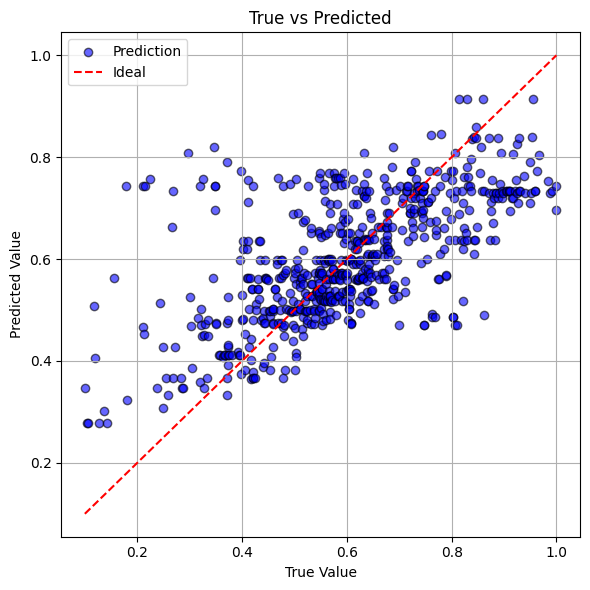

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 加载数据 ===
def load_data():
    data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')
    X = data.iloc[:, 1:44].copy()
    y = data.iloc[:, 44].copy()
    X.columns = [f'F{i+1}' for i in range(X.shape[1])]
    return data, X, y

# === 自定义 MAPE ===
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# === 符号回归模型 ===
def symbolic_model(F):
    return np.sin(np.cos((-0.72358143 / F['F35']) + 1.8737547) + F['F23']) * F['F10']

# === 主函数 ===
def main():
    data, X, y = load_data()

    # 划分训练测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120)

    # 计算预测值
    y_pred_train = symbolic_model(X_train)
    y_pred_test = symbolic_model(X_test)
    y_all = y
    y_pred_all = symbolic_model(X)

    # === 打印指标 ===
    print("\n🎯 Training Set:")
    print(f"  R²     : {r2_score(y_train, y_pred_train):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_train, y_pred_train, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_train, y_pred_train):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_train, y_pred_train):.2f}%")

    print("\n🧪 Testing Set:")
    print(f"  R²     : {r2_score(y_test, y_pred_test):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_test, y_pred_test, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_test, y_pred_test):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_test, y_pred_test):.2f}%")

    print("\n📈 Overall:")
    print(f"  R²     : {r2_score(y_all, y_pred_all):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_all, y_pred_all, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_all, y_pred_all):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_all, y_pred_all):.2f}%")

    # 加入预测与残差列
    data['Pred'] = y_pred_all
    data['residual'] = y_all - y_pred_all

    # 保存文件
    output_path = '/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3_with_pred_residual.xlsx'
    data.to_excel(output_path, index=False)
    print(f"\n✅ 已保存至: {output_path}")
    
        # 将训练集数据合并为 DataFrame 并导出
    train_indices = X_train.index
    df_train = X.loc[train_indices].copy()
    df_train['True'] = y_train
    df_train['Pred'] = y_pred_train
    df_train['Residual'] = y_train - y_pred_train
    df_train.to_excel('/Users/zixuanzhao/Desktop/Train_Prediction_Results.xlsx', index=False)

    # 将测试集数据合并为 DataFrame 并导出
    test_indices = X_test.index
    df_test = X.loc[test_indices].copy()
    df_test['True'] = y_test
    df_test['Pred'] = y_pred_test
    df_test['Residual'] = y_test - y_pred_test
    df_test.to_excel('/Users/zixuanzhao/Desktop/Test_Prediction_Results.xlsx', index=False)

    print("\n📁 训练集和测试集结果表格（含特征）已导出到桌面。")

    # 画拟合图
    plt.figure(figsize=(6, 6))
    plt.scatter(y_all, y_pred_all, c='blue', alpha=0.6, edgecolors='k', label='Prediction')
    plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', label='Ideal')
    plt.xlabel('True Value')
    plt.ylabel('Predicted Value')
    plt.title('True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

### Comparsion 2: XGBoost Model

[I 2025-05-10 00:31:02,175] A new study created in memory with name: no-name-9220a2d9-5595-41e9-bdac-8e6ba43a47b2
[I 2025-05-10 00:31:02,259] Trial 0 finished with value: 0.02758078160171517 and parameters: {'n_estimators': 232, 'max_depth': 5, 'learning_rate': 0.16450301573755172, 'subsample': 0.6202355800317705, 'colsample_bytree': 0.6315113023736214, 'gamma': 6.964101093968655, 'reg_alpha': 8.09962163284647, 'reg_lambda': 7.231108744829728}. Best is trial 0 with value: 0.02758078160171517.
[I 2025-05-10 00:31:02,469] Trial 1 finished with value: 0.02758078160171517 and parameters: {'n_estimators': 677, 'max_depth': 12, 'learning_rate': 0.04718329692476802, 'subsample': 0.9174530631307511, 'colsample_bytree': 0.8079109742833848, 'gamma': 1.876576088914833, 'reg_alpha': 6.927372246409563, 'reg_lambda': 6.724179002238372}. Best is trial 0 with value: 0.02758078160171517.
[I 2025-05-10 00:31:02,574] Trial 2 finished with value: 0.02758078160171517 and parameters: {'n_estimators': 336, '


📌 Best Parameters:
  n_estimators: 817
  max_depth: 13
  learning_rate: 0.037197376514281066
  subsample: 0.8371908517401714
  colsample_bytree: 0.761589286767861
  gamma: 0.0010325466828565247
  reg_alpha: 0.209395781295106
  reg_lambda: 0.1977632950196237

🎯 Training Set:
  R²     : 0.941747
  RMSE   : 0.043425
  MAE    : 0.030510
  MAPE   : 6.28%

🧪 Testing Set:
  R²     : 0.803783
  RMSE   : 0.073553
  MAE    : 0.052373
  MAPE   : 10.63%

📈 Overall:
  R²     : 0.917531
  RMSE   : 0.050898
  MAE    : 0.034883
  MAPE   : 7.15%


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



✅ 已保存至: /Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3_with_pred_residual.xlsx

📁 训练集和测试集预测结果已保存。


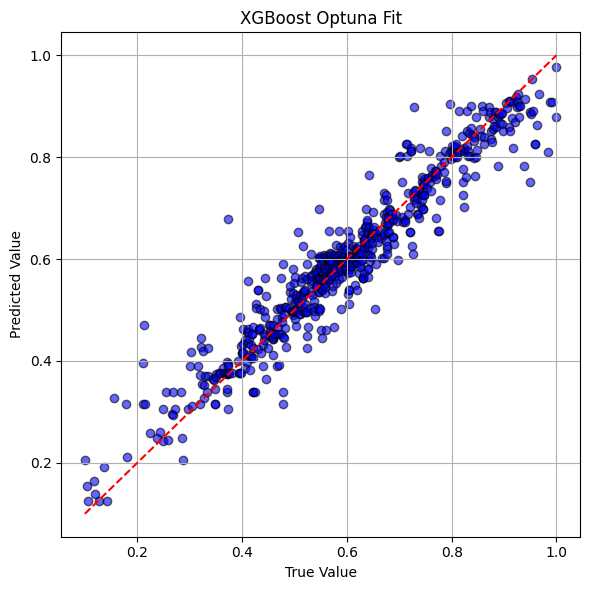

In [26]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# === 加载数据 ===
def load_data():
    data = pd.read_excel('/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3.xlsx', sheet_name='Sheet3')
    X = data.iloc[:, 1:44].copy()
    y = data.iloc[:, 44].copy()
    X.columns = [f'F{i+1}' for i in range(X.shape[1])]
    return data, X, y

# === MAPE ===
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# === Optuna目标函数 ===
def objective(trial, X_train, X_test, y_train, y_test):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42
    }
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds)

# === 主流程 ===
def main():
    data, X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    # Optuna优化
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=1000)

    print("\n📌 Best Parameters:")
    for k, v in study.best_params.items():
        print(f"  {k}: {v}")

    # 使用最优参数训练模型
    best_model = XGBRegressor(**study.best_params)
    best_model.fit(X_train, y_train)

    # 预测
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    y_pred_all = best_model.predict(X)

    # === 打印指标 ===
    print("\n🎯 Training Set:")
    print(f"  R²     : {r2_score(y_train, y_pred_train):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_train, y_pred_train, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_train, y_pred_train):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_train, y_pred_train):.2f}%")

    print("\n🧪 Testing Set:")
    print(f"  R²     : {r2_score(y_test, y_pred_test):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_test, y_pred_test, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_test, y_pred_test):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_test, y_pred_test):.2f}%")

    y_all = y
    print("\n📈 Overall:")
    print(f"  R²     : {r2_score(y_all, y_pred_all):.6f}")
    print(f"  RMSE   : {mean_squared_error(y_all, y_pred_all, squared=False):.6f}")
    print(f"  MAE    : {mean_absolute_error(y_all, y_pred_all):.6f}")
    print(f"  MAPE   : {mean_absolute_percentage_error(y_all, y_pred_all):.2f}%")

    # 加入预测与残差列
    data['Pred'] = y_pred_all
    data['residual'] = y_all - y_pred_all

    # 保存原始数据表格（含 Pred/residual）
    output_path = '/Users/zixuanzhao/Desktop/数据治理/Machine Learning/Al-Zn-Mg-Cu/Data3_with_pred_residual.xlsx'
    data.to_excel(output_path, index=False)
    print(f"\n✅ 已保存至: {output_path}")

    # 导出训练集结果
    train_indices = X_train.index
    df_train = X.loc[train_indices].copy()
    df_train['True'] = y_train
    df_train['Pred'] = y_pred_train
    df_train['Residual'] = y_train - y_pred_train
    df_train.to_excel('/Users/zixuanzhao/Desktop/XGB_Train_Results.xlsx', index=False)

    # 导出测试集结果
    test_indices = X_test.index
    df_test = X.loc[test_indices].copy()
    df_test['True'] = y_test
    df_test['Pred'] = y_pred_test
    df_test['Residual'] = y_test - y_pred_test
    df_test.to_excel('/Users/zixuanzhao/Desktop/XGB_Test_Results.xlsx', index=False)

    print("\n📁 训练集和测试集预测结果已保存。")

    # 可视化整体拟合
    plt.figure(figsize=(6, 6))
    plt.scatter(y_all, y_pred_all, c='blue', alpha=0.6, edgecolors='k')
    plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--')
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    plt.title("XGBoost Optuna Fit")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()